# Q-Learning vs Prospect Theory

In [ ]:
import sys; sys.path.insert(0, '..')
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from environment import DroneEnvironment
from agents import QLearningAgent, ProspectAgent
from training import Trainer
from evaluation import Evaluator
from utils import StateDiscretizer
from config import CHARGING_STATION_CENTER, OBSTACLES
env = DroneEnvironment(seed=11)
disc = StateDiscretizer()
n_states, n_actions = disc.get_n_states(), env.n_actions

In [ ]:
q = QLearningAgent(n_states, n_actions, alpha=0.15, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.997)
q_h = Trainer(env, q, disc).train(15000)

Training Q-Learning (Rational): 100%|██████████| 15000/15000 [00:57<00:00, 262.76it/s, success=0.00%, eps=0.01] 


In [ ]:
pt = ProspectAgent(n_states, n_actions, alpha=0.88, beta=0.88, lambda_=2.35, learning_rate=0.15, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.997)
pt_h = Trainer(DroneEnvironment(seed=11), pt, disc).train(15000)

Training Prospect Theory (Behavioral): 100%|██████████| 15000/15000 [01:12<00:00, 207.26it/s, success=0.00%, eps=0.01]


In [ ]:
ev = Evaluator(env, disc); q_m = ev.evaluate(q, 300, 0.005); pt_m = ev.evaluate(pt, 300, 0.005)
print(f"Q-Learning: {q_m['success_rate']:.1f}% | Prospect: {pt_m['success_rate']:.1f}%")

Testing Prospect Theory (Behavioral): 100%|██████████| 300/300 [00:01<00:00, 243.94it/s]

Q-Learning: 43.3% | Prospect: 0.0%


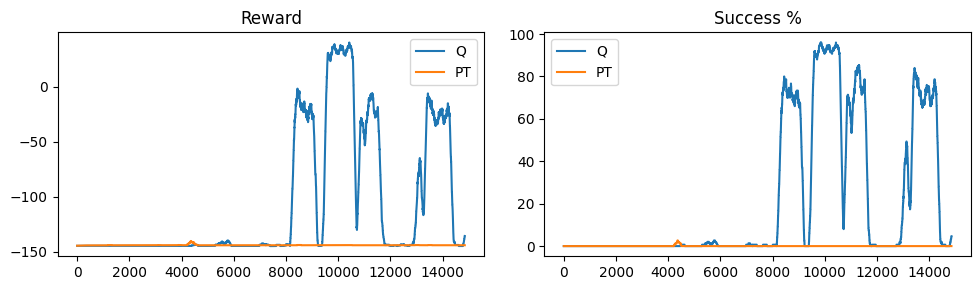

In [ ]:
sm = lambda x: np.convolve(x, np.ones(150)/150, 'valid')
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(sm(q_h['rewards']), label='Q'); ax[0].plot(sm(pt_h['rewards']), label='PT'); ax[0].legend(); ax[0].set_title('Reward')
ax[1].plot(sm(q_h['successes'].astype(float))*100, label='Q'); ax[1].plot(sm(pt_h['successes'].astype(float))*100, label='PT'); ax[1].legend(); ax[1].set_title('Success %')
plt.tight_layout(); plt.show()

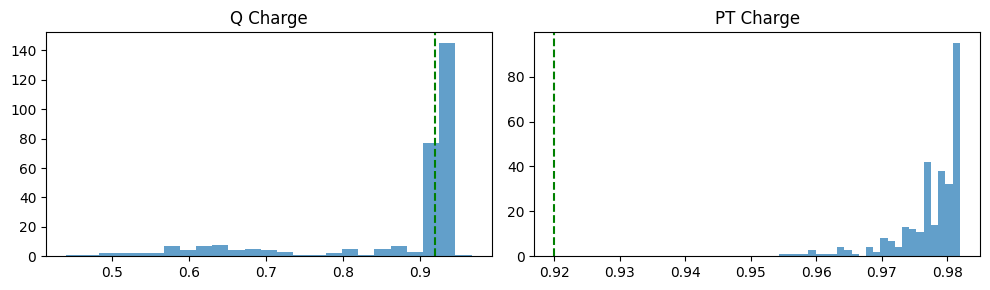

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for a, m, n in [(ax[0], q_m, 'Q'), (ax[1], pt_m, 'PT')]: a.hist(m['raw_charges'], 25, alpha=0.7); a.axvline(0.92, c='g', ls='--'); a.set_title(f'{n} Charge')
plt.tight_layout(); plt.show()

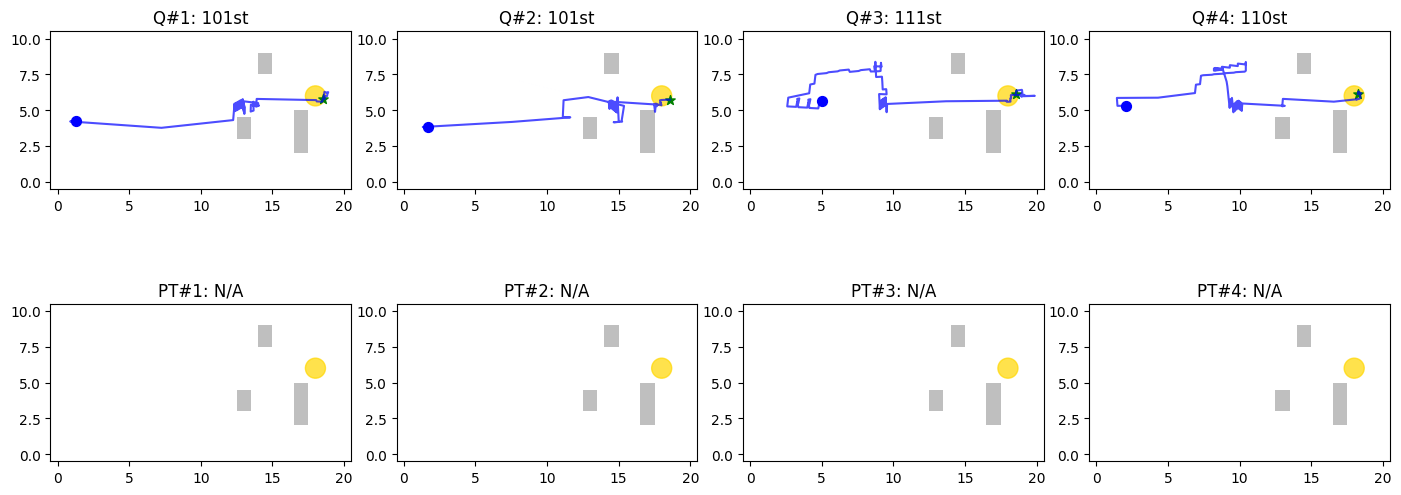

In [ ]:
q_tr, pt_tr = ev.collect_trajectories(q, 4, 0.005), ev.collect_trajectories(pt, 4, 0.005)
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for row, (trs, nm) in enumerate([(q_tr, 'Q'), (pt_tr, 'PT')]):
    for i in range(4):
        ax = axes[row, i]; ax.set_xlim(-0.5, 20.5); ax.set_ylim(-0.5, 10.5); ax.set_aspect('equal')
        ax.add_patch(plt.Circle(CHARGING_STATION_CENTER, 0.7, color='gold', alpha=0.7))
        for o in OBSTACLES: ax.add_patch(patches.Rectangle((o[0], o[1]), o[2]-o[0], o[3]-o[1], fc='gray', alpha=0.5))
        if i < len(trs) and trs[i].trajectory:
            tr = trs[i]; xs, ys = [s.position[0] for s in tr.trajectory], [s.position[1] for s in tr.trajectory]
            ax.plot(xs, ys, 'b-', alpha=0.7); ax.scatter(xs[0], ys[0], c='b', s=50); ax.scatter(xs[-1], ys[-1], c='g', s=50, marker='*')
            ax.set_title(f'{nm}#{i+1}: {tr.steps}st')
        else: ax.set_title(f'{nm}#{i+1}: N/A')
plt.tight_layout(); plt.show()

In [ ]:
print(f"{'Metric':<15} {'Q-Learning':<12} {'Prospect':<12}\n" + "="*40)
print(f"{'Success %':<15} {q_m['success_rate']:<12.1f} {pt_m['success_rate']:<12.1f}")
print(f"{'Collision %':<15} {q_m['collision_rate']:<12.1f} {pt_m['collision_rate']:<12.1f}")
t, p = stats.ttest_ind(q_m['raw_rewards'], pt_m['raw_rewards']); print(f"\nt-test: t={t:.2f}, p={p:.4f} {'***' if p<0.05 else ''}")

Metric          Q-Learning   Prospect    
Success %       43.3         0.0         
Collision %     41.7         0.0         

t-test: t=18.70, p=0.0000 ***
